In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from sgmbasketball.models.factor_model.play_by_play_data import PlayByPlayCleanData
from stratagemdataprocessing.data_api import find_basketball_events
from IPython.display import clear_output

from scipy.misc import logsumexp
from scipy.stats import norm

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 6)

In [5]:
START_DT = datetime.datetime(2016, 10, 1)
END_DT = datetime.datetime(2016, 11, 1)

ALL_EVENTS = find_basketball_events(START_DT, END_DT, True)
NBA_EVENTS = filter(lambda e: e['stage_name'] == 'NBA', ALL_EVENTS)

PBP = PlayByPlayCleanData(str(START_DT)[0:10], str(END_DT)[0:10], 'NBA', 'pbp', fixture_filter=None).get_data_ready()
clear_output()

In [6]:
def Filtering(V, std_eta, pitgitm1, pi2):
    # initialise
    T = len(V)
    logV = np.log(V)

    logpitgitm1 = np.log(pitgitm1)
    logalpha = np.zeros([T, 2])

    fstats = {'logareaw': -np.inf*np.ones([T, T-1]),
              'logmoment1w': -np.inf*np.ones([T, T-1], dtype=complex),
              'logmoment2w': -np.inf*np.ones([T, T-1])}
   
    # first time-step (t=1)
    t = 1
    loglik = 0
    
    # prepare p( i_{t+1} | i_t )
    logpitp1git = np.zeros([2, 2])
    logpitp1git[0, :] = np.log(pi2[0])
    logpitp1git[1, :] = np.log(pi2[1])
    
    # remaining time-steps:
    lnpdfs = norm.logpdf(V[t:], loc=V[:-1], scale=std_eta)

    for t in range(1, T):
        logft = np.zeros(t, dtype=complex)
        logFt = np.zeros(t)
        logwt = np.zeros(t)

        # it=1
        logZ10 = lnpdfs[t-1] + logpitp1git[1,0]
        logZ11 = lnpdfs[t-1] + logpitp1git[1,1]

        # it=0  --- the interesting case!
        
        # new component
        logft[0] = logV[t] - logV[t-1]
        logFt[0] = (2*np.log(std_eta) - 2*logV[t-1]).real
        logwt[0] = logpitp1git[0,1] - np.log(np.abs(V[t-1]))
    
        # existing components
        if t > 1:
            bottomparts = logsumexp(np.concatenate(
                [np.tile(2*np.log(std_eta), (t-1,1)), 2*logV[t-1] + np.atleast_2d(logFtm1).T], axis=1),
                                    axis=1).real

            logft[1:] = logsumexp([logftm1 + 2*np.log(std_eta), logFtm1 + logV[t] + logV[t-1]], axis=0) - bottomparts
            logFt[1:] = (2*np.log(std_eta) + logFtm1 - bottomparts).real
            logwt[1:] = logpitp1git[0,0] + logwtm1 + norm.logpdf(V[t], loc=np.exp(logV[t-1] + logftm1).real, 
                                                                       scale=np.exp(0.5 * bottomparts))

        logarea = calc_log_area_log(logft,logFt)
        logmoment1, logmoment2 = calc_log_moments_log(logft, logFt, logarea)
        logZ01 = logwt[0] + logarea[0]

        if t == 1:
            logZ00prefactor = logpitp1git[0,0] - np.log(np.abs(V[t-1]))
            logwt[0] = logsumexp([logwt[0], logZ00prefactor])
            logZ00 = logZ00prefactor + logarea[0]
        else:
            logZ00 = logsumexp(logwt[1:] + logarea[1:])
        
        logZ0 = logsumexp([logZ00, logZ01]); logZ1 = logsumexp([logZ10, logZ11])
        logZ = logsumexp([logZ00, logZ01, logZ10, logZ11])
        logalpha[t,0] = logZ0 - logZ
        logalpha[t,1] = logZ1 - logZ
        
        logwt = logwt - logZ0
        assert logwt[0] != 0
        
        # store stats times w
        fstats['logareaw'][t,0:t] = logarea[:t] + logwt
        fstats['logmoment1w'][t,0:t] = logmoment1[:t] + logwt + logarea
        fstats['logmoment2w'][t,0:t] = logmoment2[:t] + logwt + logarea
        
        loglik = (loglik + logZ).real
        
        # update registers
        logftm1 = logft; logFtm1 = logFt; logwtm1 = logwt

        # prepare p( i_{t+1} | i_t )
        logpitp1git[0,:] = logpitgitm1[0,:] + logalpha[t,:]
        logpitp1git[1,:] = logpitgitm1[1,:] + logalpha[t,:]

    return logalpha, loglik, fstats

In [7]:
def Smoothing(pitgitm1,logalpha,fstats):
    # initialise
    T = len(logalpha)
    logpitgitm1 = np.log(pitgitm1)
    
    # time t=T
    loggamma = np.zeros([T,2])
    loggamma[-1,:] = logalpha[-1,:]
  
    # calculate first and second moments for EM
    logmoment1 = np.zeros(T, dtype=complex)
    logmoment2 = np.zeros(T)
    logmoment1[-1] = logsumexp(np.append(logalpha[-1,0]+fstats['logmoment1w'][-1,:],logalpha[-1,1]))
    logmoment2[-1] = logsumexp(np.append(logalpha[-1,0]+fstats['logmoment2w'][-1,:],logalpha[-1,1]))
    
    # t<T
    logprefactors1 = np.zeros(0)
    lses = logsumexp(logpitgitm1[1,:] + logalpha, axis=1)
    for t in reversed(range(T-1)):

        logintegralprefactor = logalpha[-1,0] + fstats['logareaw'][-1,-t-1] # the component from T
        if t > 0: # components from T
            logmoment1T = logalpha[-1,0] + logsumexp(fstats['logmoment1w'][-1,-t:])
            logmoment2T = logalpha[-1,0] + logsumexp(fstats['logmoment2w'][-1,-t:])
        else:
            logmoment1T = -np.inf
            logmoment2T = -np.inf

        # components from t:T-1        
        logprefactors1 = np.insert(logprefactors1,0,loggamma[t+1,1] + logpitgitm1[1,0] + logalpha[t,0] - lses[t])

        ftsatslogareaws = fstats['logareaw'][range(t+1,T-1),range(T-t-2)]
        logintegralparts = logprefactors1[1:] + ftsatslogareaws
        
        diagonals = np.tile(range(t,T-1),(t,1)).T,[range(s,t+s) for s in range(T-t-1)]
        logmoment1parts = (logprefactors1 + logsumexp(fstats['logmoment1w'][diagonals], axis=1)) if t else []
        logmoment2parts = (logprefactors1 + logsumexp(fstats['logmoment2w'][diagonals], axis=1)) if t else []
        
        loggamma[t,1] = logsumexp(np.concatenate([[logintegralprefactor], logintegralparts,
                                   [loggamma[t+1,1] + logpitgitm1[1,1] + logalpha[t,1]
                                     - logsumexp(logpitgitm1[1,:] + logalpha[t,:])]]))

        if t > 0:
            logmoment1[t] = logsumexp(np.concatenate([[logmoment1T], logmoment1parts, [loggamma[t,1]]]))
            logmoment2[t] = logsumexp(np.concatenate([[logmoment2T], logmoment2parts, [loggamma[t,1]]]))
    
    gamma = np.zeros([T,2])
    gamma[:,1] = np.exp(loggamma[:,1])
    gamma[:,0] = 1 - gamma[:,1]
    loggamma[:,0] = np.log(gamma[:,0])
    moment1 = np.exp(logmoment1).real
    moment2 = np.exp(logmoment2).real
    
    return loggamma, moment1, moment2

In [8]:
def EMUpdate(x, y, moment1, moment2):
    T = x.size
    xt, xtm1 = x[1:], x[:-1]
    yt, ytm1 = y[1:], y[:-1]
    
    # find the coefficients
    a = 2 * sum(moment1[1:]) - sum(moment2[1:]) - (T-1)
    b = sum(moment1[1:] * (xt + xtm1)) - sum(moment2[1:] * xtm1) - sum(xt)
    c = sum(moment2[1:] * ytm1) - sum(moment1[1:] * (yt + ytm1)) + sum(yt)
    d = 2 * sum(moment1[1:] * xt * xtm1) - sum(moment2[1:] * (xtm1 ** 2)) - sum(xt ** 2)
    e = sum(moment2[1:] * xtm1 * ytm1) - sum(moment1[1:] * (xtm1 * yt + xt * ytm1)) + sum(xt * yt)
        
    # solve simultaneous equations
    slope = ((a * e) - (c * b)) / ((b ** 2) - (a * d))
    intercept = (-slope * d / b) - (e / b)

    # now find optimal sigma
    eps = y - intercept - slope * x
    ept, eptm1 = eps[1:], eps[:T-1]
    std_eta = np.sqrt((np.sum(ept**2) - 2*np.sum(moment1[1:]*ept*eptm1) + np.sum(moment2[1:]*eptm1**2))/(T-1))

    assert std_eta > 0, "Standard deviation must be positive"
    assert np.isreal(std_eta), "Standard deviation must be real"

    return slope, intercept, std_eta

In [9]:
def linear_regression(x, y):
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x, y)

    return slope, intercept, np.std(y - intercept - slope*x, ddof=1)

In [10]:
def infer_coint(epsilon, std_eta, pitgitm1, pi2):
    logalpha, loglik, fstats = Filtering(epsilon, std_eta, pitgitm1, pi2)
    loggamma, moment1, moment2 = Smoothing(pitgitm1, logalpha, fstats)

    return logalpha, loglik, loggamma, moment1, moment2

In [11]:
def calc_log_area_log(logf, logF):
    logf = np.array(logf)
    logF = np.array(logF)

    ones = np.tile([1, -1], logf.shape+(1,)).T

    lncdf = norm.logcdf(ones, loc=np.exp(logf).real, scale=np.exp(0.5*np.array(logF)).real)
    logarea = logsumexp(lncdf, b=ones, axis=0) - np.log(2)

    return logarea

In [12]:
def calc_log_moments_log(logf,logF,logarea):
    logf = np.array(logf)
    logF = np.array(logF)

    ones = np.tile([1, -1], logf.shape+(1,)).T

    lnpdfplogFmlogarea = norm.logpdf(ones, loc=np.exp(logf).real,
                                     scale=np.exp(0.5*logF).real) + logF - logarea
    
    logmoment1 = logsumexp(np.concatenate([lnpdfplogFmlogarea, [logf]]),
                           b=np.tile([-0.5, 0.5, 1], logf.shape+(1,)).T, axis=0)

    logmoment2 = logsumexp(np.concatenate([logf+lnpdfplogFmlogarea, lnpdfplogFmlogarea, [2*logf], [logF]]),
                           b=np.tile([-0.5, 0.5, -0.5, -0.5, 1, 1], logf.shape+(1,)).T, axis=0).real

    return logmoment1, logmoment2

In [13]:
def get_sample(eid):
    data = PBP.loc[eid]

    return data[['points_h', 'points_a']].values

In [14]:
def plot_scores(scores, ax):
    ax.plot(scores)
    ax.legend(['Team 1', 'Team 2'], loc='best')
    ax.set_ylabel('Score [-]')
    ax.set_xlabel('Event [-]')

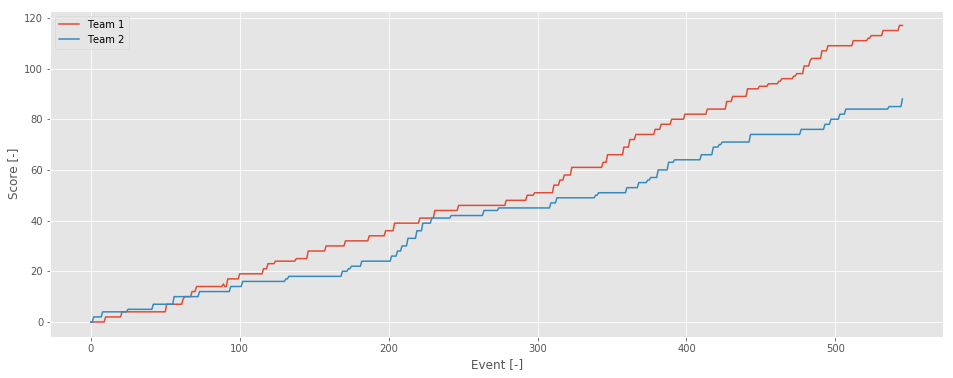

In [17]:
X = get_sample(2352830)
plot_scores(X, plt.subplots(1)[1])

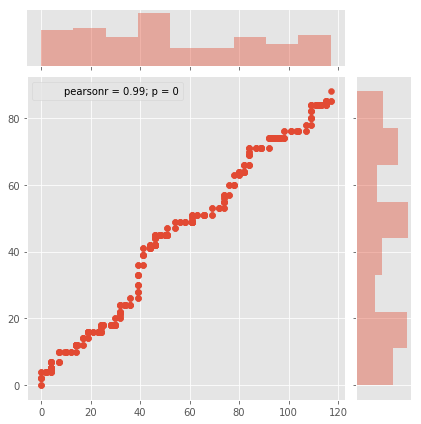

In [18]:
sns.jointplot(X[:, 0], X[:, 1])

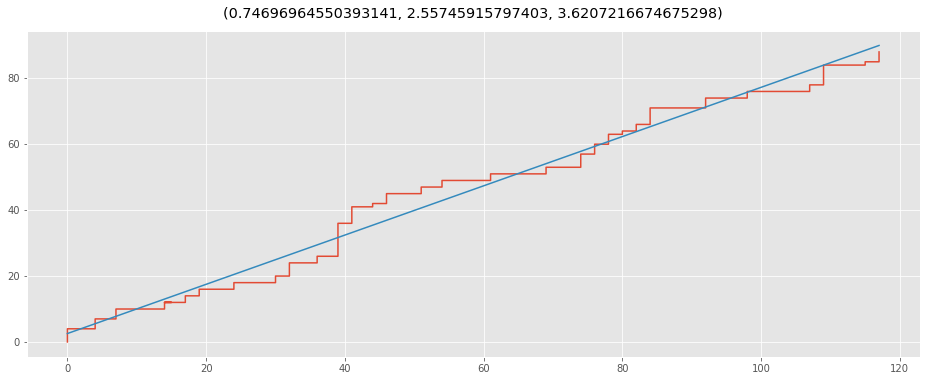

In [19]:
ps = linear_regression(X[:, 0], X[:, 1])

plt.step(X[:, 0], X[:, 1])
plt.plot(X[:, 0], np.poly1d(ps[0:2])(X[:, 0]))
plt.title(ps, y=1.02)

/home/dedwards/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/home/dedwards/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/dedwards/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/dedwards/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/dedwards/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1779: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/home/dedwards/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWar

AssertionError: Standard deviation must be positive

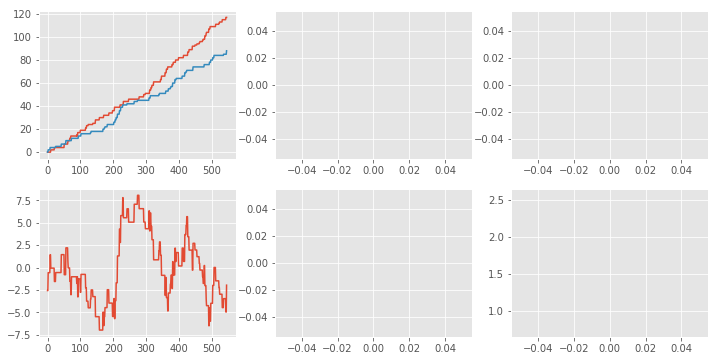

In [20]:
x, y = X[:, 0], X[:, 1]

pi2 = np.array([[0.95], [0.05]])

pitgitm1 = np.zeros((2, 2))
pitgitm1[0,0] = 1 - 1.0/230
pitgitm1[0,1] = 1.0/15
pitgitm1[1,:] = 1 - pitgitm1[0,:]

slope, interc, std_eta = linear_regression(x, y)

slopes = []
intercs = []
std_etas = []
logliks = [-np.inf]

fig, ax = plt.subplots(2,3,figsize=(12, 6), num="Intermittent Cointegration Inference: Gas")
ax[0, 0].plot(x)
ax[0, 0].plot(y)

for i in range(1000):
    slopes.append(slope)
    intercs.append(interc)
    std_etas.append(std_eta)

    ax[1, 2].step(range(i+1), slopes)
    ax[1, 2].step(range(i+1), intercs)

    # calculate epsilon
    epsilon = y-interc-slope*x
    ax[1, 0].plot(epsilon)

    logalpha, loglik, loggamma, moment1, moment2 = infer_coint(epsilon, std_eta, pitgitm1, pi2)

    alpha = np.exp(logalpha).real
    logliks.append(loglik)
    ax[0, 2].plot(range(i+1), logliks[1:])

    # plot cointegration filtered posterior
    ax[0, 1].plot(alpha[1:, 1])

    gamma = np.exp(loggamma).real
    ax[0, 1].plot(gamma[1:, 1])

    # plot moment1 with error
    ax[1, 1].clear()
    ax[1, 1].plot(moment1[1:])
    ax[1, 1].fill_between(ax[1, 1].lines[0].get_xdata(),
                          moment1[1:]-np.sqrt(moment2[1:]-moment1[1:]**2),
                          moment1[1:]+np.sqrt(moment2[1:]-moment1[1:]**2),
                          facecolor='blue', alpha=0.3, linewidth=0)

    slope, interc, std_eta = EMUpdate(x, y, moment1, moment2)

    if logliks[-1]-logliks[-2] < 0.0001:
        break

print "slope,intercept,std_eta"
print slope,interc,std_eta